#  Data Collection and Integration

### Import Required Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

### Load the Datasets

In [2]:
# Load datasets
traffic_df = pd.read_csv("Dataset_Uber Traffic.csv")
weather_df = pd.read_csv("Delhi_NCR_2015_2016.csv")
holiday_df = pd.read_csv("Holidays 2015 to 2016.csv")

### Convert Date Columns to Datetime

In [3]:
# Convert traffic DateTime
traffic_df['DateTime'] = pd.to_datetime(traffic_df['DateTime'], format='%d/%m/%y %H:%M')

In [4]:
# Convert weather date
weather_df['date'] = pd.to_datetime(weather_df['date'], format='%d-%m-%Y')

In [5]:
holiday_df['Date'] = pd.to_datetime(holiday_df['Date'], format='%d-%m-%Y')
holiday_df['Date'] = pd.to_datetime(holiday_df['Date'], dayfirst=True, errors='coerce')

## Preview the Date Ranges in Each Dataset

In [6]:
print("Traffic Date Range:", traffic_df['DateTime'].min(), "to", traffic_df['DateTime'].max())
print("Weather Date Range:", weather_df['date'].min(), "to", weather_df['date'].max())
print("Holiday Date Range:", holiday_df['Date'].min(), "to", holiday_df['Date'].max())

Traffic Date Range: 2015-11-01 00:00:00 to 2017-06-30 23:00:00
Weather Date Range: 2015-01-01 00:00:00 to 2016-12-31 00:00:00
Holiday Date Range: 2015-01-04 00:00:00 to 2016-12-13 00:00:00


### Extract Date from Traffic Timestamp

In [7]:
traffic_df['Date'] = traffic_df['DateTime'].dt.date

In [8]:
weather_df['Date'] = weather_df['date'].dt.date

### Merge traffic + weather on 'Date'

In [9]:
merged_df = pd.merge(traffic_df, weather_df, on='Date', how='left')

### Drop the extra columns not needed

In [10]:
merged_df.drop(['date'], axis=1, inplace=True)

### Preview merged data

In [11]:
merged_df.head()

,DateTime,Junction,Vehicles,ID,Date,tavg,tmin,tmax,prcp
0,2015-11-01 00:00:00,1,15,20151101001,2015-11-01,22.9,16.2,31.4,NaN
1,2015-11-01 01:00:00,1,13,20151101011,2015-11-01,22.9,16.2,31.4,NaN
2,2015-11-01 02:00:00,1,10,20151101021,2015-11-01,22.9,16.2,31.4,NaN
3,2015-11-01 03:00:00,1,7,20151101031,2015-11-01,22.9,16.2,31.4,NaN
4,2015-11-01 04:00:00,1,9,20151101041,2015-11-01,22.9,16.2,31.4,NaN


## Clean and Standardize Holiday Dates

In [12]:
holiday_df.rename(columns={'Holiday Date': 'Date'}, inplace=True)
holiday_df['Date'] = pd.to_datetime(holiday_df['Date'])
holiday_df['Only_Date'] = holiday_df['Date'].dt.date

### Create a 'IsHoliday' flag

In [13]:
holiday_df['IsHoliday'] = 1

In [14]:
# Ensure both 'Date' columns are in datetime64[ns] format
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
holiday_df['Date'] = pd.to_datetime(holiday_df['Date'])

# Now safely merge
merged_df = pd.merge(merged_df, holiday_df[['Date', 'IsHoliday']], on='Date', how='left')

In [15]:
# Step 4: Fill non-holiday entries with 0
merged_df['IsHoliday'] = merged_df['IsHoliday'].fillna(0).astype(int)

### Preview the updated dataset

In [16]:
merged_df.head()

,DateTime,Junction,Vehicles,ID,Date,tavg,tmin,tmax,prcp,IsHoliday
0,2015-11-01 00:00:00,1,15,20151101001,2015-11-01,22.9,16.2,31.4,NaN,0
1,2015-11-01 01:00:00,1,13,20151101011,2015-11-01,22.9,16.2,31.4,NaN,0
2,2015-11-01 02:00:00,1,10,20151101021,2015-11-01,22.9,16.2,31.4,NaN,0
3,2015-11-01 03:00:00,1,7,20151101031,2015-11-01,22.9,16.2,31.4,NaN,0
4,2015-11-01 04:00:00,1,9,20151101041,2015-11-01,22.9,16.2,31.4,NaN,0


### Check for missing values in merged dataset

In [17]:
print("Missing Values:\n", merged_df.isnull().sum())

Missing Values:
 DateTime         0
Junction         0
Vehicles         0
ID               0
Date             0
tavg         17376
tmin         17808
tmax         17520
prcp         40920
IsHoliday        0
dtype: int64


In [18]:
#  Remove rows with missing 'Vehicles' (this is essential data)
merged_df = merged_df.dropna(subset=['Vehicles'])

In [19]:
# For weather columns (tavg, tmin, tmax, prcp), fill with median values
weather_cols = ['tavg', 'tmin', 'tmax', 'prcp']
for col in weather_cols:
    merged_df[col] = merged_df[col].fillna(merged_df[col].median())

In [20]:
# Remove duplicates
merged_df = merged_df.drop_duplicates()

In [21]:

# Ensure correct data types
merged_df['Vehicles'] = merged_df['Vehicles'].astype(int)
merged_df['IsHoliday'] = merged_df['IsHoliday'].astype(int)

In [22]:
#  Final check
print("\n Cleaned Data Types:\n", merged_df.dtypes)
print("\n Final Dataset Shape:", merged_df.shape)


 Cleaned Data Types:
 DateTime     datetime64[ns]
Junction              int64
Vehicles              int32
ID                    int64
Date         datetime64[ns]
tavg                float64
tmin                float64
tmax                float64
prcp                float64
IsHoliday             int32
dtype: object

 Final Dataset Shape: (48120, 10)


In [23]:
merged_df.head(5)

,DateTime,Junction,Vehicles,ID,Date,tavg,tmin,tmax,prcp,IsHoliday
0,2015-11-01 00:00:00,1,15,20151101001,2015-11-01,22.9,16.2,31.4,0.15,0
1,2015-11-01 01:00:00,1,13,20151101011,2015-11-01,22.9,16.2,31.4,0.15,0
2,2015-11-01 02:00:00,1,10,20151101021,2015-11-01,22.9,16.2,31.4,0.15,0
3,2015-11-01 03:00:00,1,7,20151101031,2015-11-01,22.9,16.2,31.4,0.15,0
4,2015-11-01 04:00:00,1,9,20151101041,2015-11-01,22.9,16.2,31.4,0.15,0


In [24]:
# Extract hour of day (0 to 23)
merged_df['Hour'] = merged_df['DateTime'].dt.hour

In [25]:

# Extract day of the week (0 = Monday, 6 = Sunday)
merged_df['DayOfWeek'] = merged_df['DateTime'].dt.dayofweek

In [26]:
# Flag if the day is a weekend (Saturday=5, Sunday=6)
merged_df['IsWeekend'] = merged_df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

In [27]:
# Flag if it's a rush hour (7–10 AM or 5–8 PM)
merged_df['IsRushHour'] = merged_df['Hour'].apply(lambda x: 1 if (7 <= x <= 10) or (17 <= x <= 20) else 0)

In [28]:
# Display first few rows with new time-based features
merged_df[['DateTime', 'Hour', 'DayOfWeek', 'IsWeekend', 'IsRushHour']].head()

,DateTime,Hour,DayOfWeek,IsWeekend,IsRushHour
0,2015-11-01 00:00:00,0,6,1,0
1,2015-11-01 01:00:00,1,6,1,0
2,2015-11-01 02:00:00,2,6,1,0
3,2015-11-01 03:00:00,3,6,1,0
4,2015-11-01 04:00:00,4,6,1,0


## Rush Hour vs Non-Rush Hour

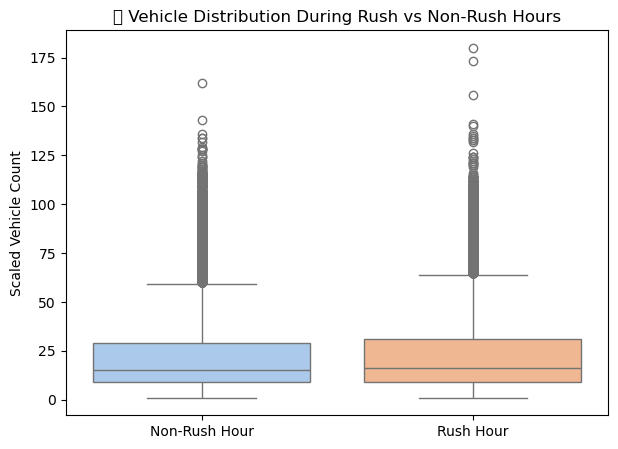

In [29]:

plt.figure(figsize=(7, 5))
sns.boxplot(x='IsRushHour', y='Vehicles', data=merged_df, palette='pastel')
plt.xticks([0, 1], ['Non-Rush Hour', 'Rush Hour'])
plt.title('⏰ Vehicle Distribution During Rush vs Non-Rush Hours')
plt.xlabel('')
plt.ylabel('Scaled Vehicle Count')
plt.show()

## Vehicles by Day of Week

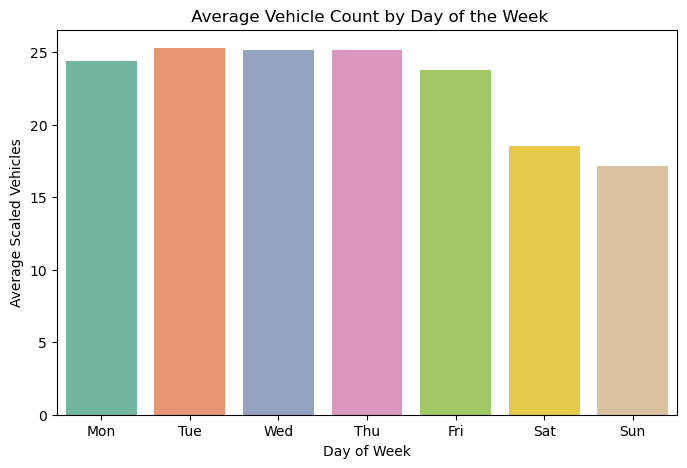

In [30]:
# Average vehicles per day of the week
dow_traffic = merged_df.groupby('DayOfWeek')['Vehicles'].mean().reset_index()

# Day names for better understanding
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dow_traffic['DayName'] = dow_traffic['DayOfWeek'].apply(lambda x: days[x])

plt.figure(figsize=(8, 5))
sns.barplot(data=dow_traffic, x='DayName', y='Vehicles', palette='Set2')
plt.title(' Average Vehicle Count by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Scaled Vehicles')
plt.show()

### Vehicles by Hour of the Day

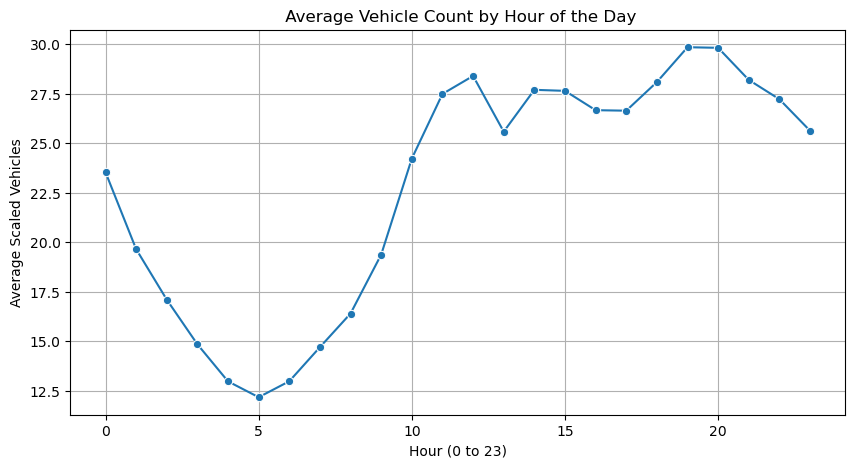

In [31]:
# Average vehicles per hour
hourly_traffic = merged_df.groupby('Hour')['Vehicles'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=hourly_traffic, x='Hour', y='Vehicles', marker='o')
plt.title(' Average Vehicle Count by Hour of the Day')
plt.xlabel('Hour (0 to 23)')
plt.ylabel('Average Scaled Vehicles')
plt.grid(True)
plt.show()

# Normalize Numerical Features Using StandardScaler

In [32]:
from sklearn.preprocessing import StandardScaler

# Step 1: Columns to scale
scale_cols = ['Vehicles', 'tavg', 'tmin', 'tmax', 'prcp']

In [33]:
# Step 2: Initialize the scaler
scaler = StandardScaler()

In [34]:
# Step 3: Apply scaler
merged_df[scale_cols] = scaler.fit_transform(merged_df[scale_cols])

In [35]:
# Step 4: Show first few rows
merged_df[scale_cols + ['Junction', 'IsHoliday', 'DateTime']].head()

,Vehicles,tavg,tmin,tmax,prcp,Junction,IsHoliday,DateTime
0,-0.375489,-0.559729,-0.420101,-0.274024,-0.161477,1,0,2015-11-01 00:00:00
1,-0.471875,-0.559729,-0.420101,-0.274024,-0.161477,1,0,2015-11-01 01:00:00
2,-0.616454,-0.559729,-0.420101,-0.274024,-0.161477,1,0,2015-11-01 02:00:00
3,-0.761034,-0.559729,-0.420101,-0.274024,-0.161477,1,0,2015-11-01 03:00:00
4,-0.664648,-0.559729,-0.420101,-0.274024,-0.161477,1,0,2015-11-01 04:00:00


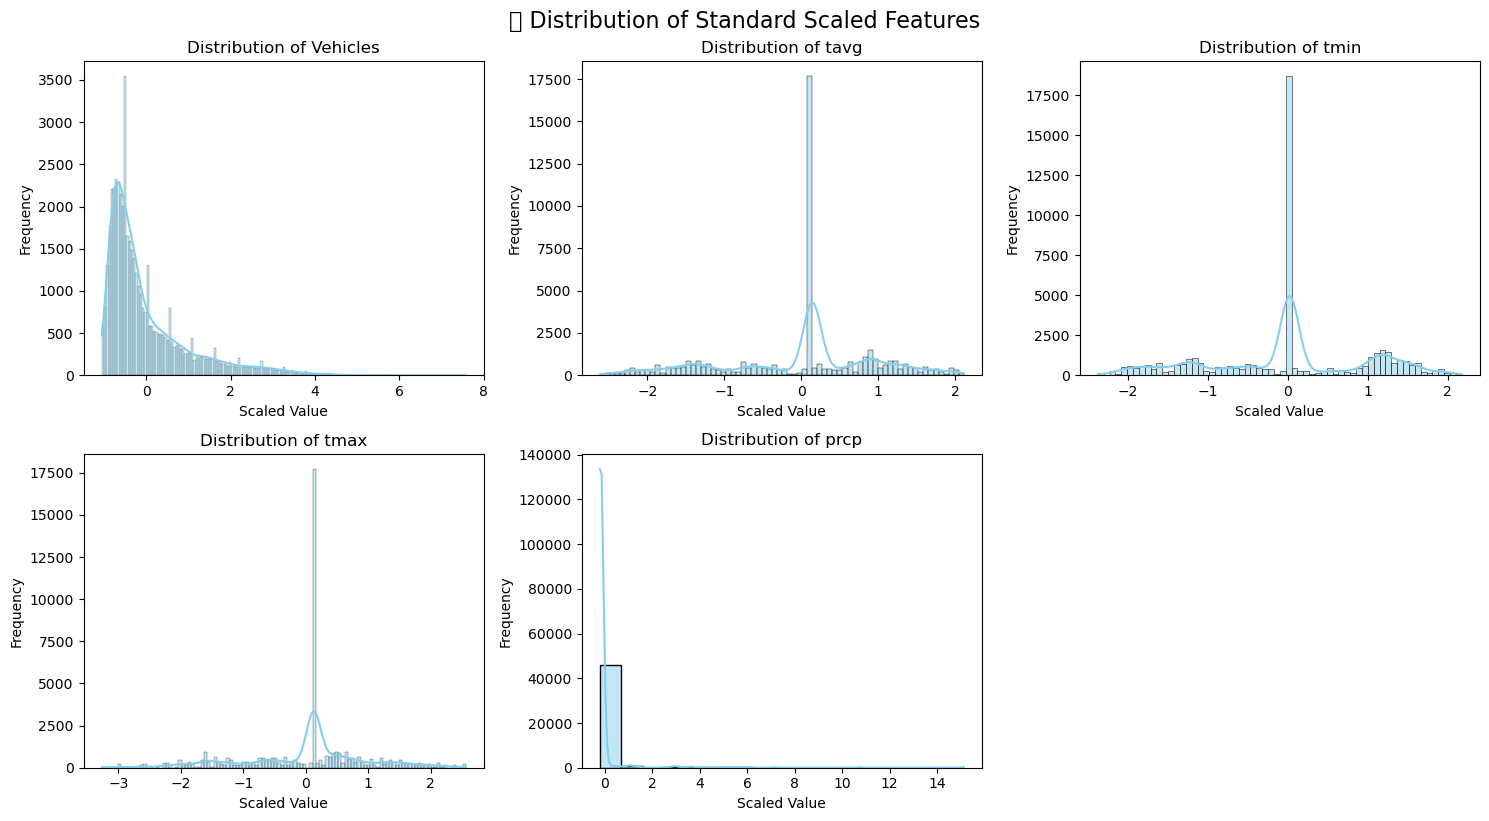

In [37]:
scale_cols = ['Vehicles', 'tavg', 'tmin', 'tmax', 'prcp']

plt.figure(figsize=(15, 8))
for i, col in enumerate(scale_cols):
    plt.subplot(2, 3, i + 1)
    sns.histplot(merged_df[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel('Scaled Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.suptitle(' Distribution of Standard Scaled Features', fontsize=16, y=1.02)
plt.show()

In [38]:
# Save the final cleaned and merged dataset
merged_df.to_csv("Final_Merged_Dataset.csv", index=False)

print(" Final merged dataset saved successfully as 'Final_Merged_Dataset.csv'")

 Final merged dataset saved successfully as 'Final_Merged_Dataset.csv'
